In [257]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import random
import joblib


torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class EWC:
    def __init__(self, model, dataloader, criterion):
        self.model = model
        self.criterion = criterion
        self.dataloader = dataloader
        self.params = {n: p.clone().detach() for n, p in model.named_parameters() if p.requires_grad}
        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.model.eval()
        for x, y in self.dataloader:
            self.model.zero_grad()
            out = self.model(x)
            loss = self.criterion(out.squeeze(-1), y)
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.requires_grad:
                    precision[n] += p.grad.data.pow(2)
        return {n: p / len(self.dataloader) for n, p in precision.items()}

    def penalty(self, model):
        return sum((self._precision_matrices[n] * (p - self.params[n]).pow(2)).sum()
                   for n, p in model.named_parameters() if p.requires_grad)

class CabbagePredictor:
    def __init__(self, window=12, epochs=5, lr=1e-3, lambda_ewc=20):
        self.WINDOW = window
        self.EPOCHS = epochs
        self.LR = lr
        self.LAMBDA_EWC = lambda_ewc
        self.feature_cols = ['intake', 'gap', 'price_diff', 'rolling_mean', 'rolling_std']
        self.target_col = 'log_price'
        self.criterion = nn.MSELoss()
        self.results = []
        self.model = LSTMModel(input_size=len(self.feature_cols))
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.LR)

    def _get_prefix(self, rate):
        return "special" if rate.lower() == "special" else "high"

    def save(self, rate):
        prefix = self._get_prefix(rate)
        torch.save(self.model.state_dict(), f"{prefix}_model.pth")
        joblib.dump(self.scaler_x, f"{prefix}_scaler_x.pkl")
        joblib.dump(self.scaler_y, f"{prefix}_scaler_y.pkl")

    def load(self, rate):
        prefix = self._get_prefix(rate)
        self.model.load_state_dict(torch.load(f"{prefix}_model.pth"))
        self.model.eval()
        self.scaler_x = joblib.load(f"{prefix}_scaler_x.pkl")
        self.scaler_y = joblib.load(f"{prefix}_scaler_y.pkl")
        self.ewc_list = []

    def fit(self, df_raw, cutoff_date="2025-06-01", months=[5, 6], rate="HIGH"):
        self.rate = rate
        df = df_raw[df_raw['rate'] == rate].copy()
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        df = df[df['month'].isin(months)].sort_values('date').reset_index(drop=True)
        df['prev_price'] = df['avg_price'].shift(1)
        df['price_diff'] = df['avg_price'] - df['prev_price']
        df['rolling_mean'] = df['avg_price'].rolling(window=3).mean()
        df['rolling_std'] = df['avg_price'].rolling(window=3).std()
        df = df.dropna()
        df['log_price'] = np.log1p(df['avg_price'])

        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        df[self.feature_cols] = self.scaler_x.fit_transform(df[self.feature_cols])
        df[[self.target_col]] = self.scaler_y.fit_transform(df[[self.target_col]])

        self.df = df.reset_index(drop=True)
        self.dates = df['date'].values

        X_seq, y_seq, date_seq = [], [], []
        for i in range(len(df) - self.WINDOW):
            window = df.iloc[i:i + self.WINDOW]
            target = df.iloc[i + self.WINDOW]
            X_seq.append(window[self.feature_cols].values)
            y_seq.append(target[self.target_col])
            date_seq.append(target['date'])

        self.X_seq = torch.tensor(np.array(X_seq), dtype=torch.float32)
        self.y_seq = torch.tensor(np.array(y_seq), dtype=torch.float32)
        self.date_seq = date_seq

        cutoff = pd.to_datetime(cutoff_date)
        init_idx = [i for i, d in enumerate(self.date_seq) if d <= cutoff]
        X_init = self.X_seq[init_idx]
        y_init = self.y_seq[init_idx]
        init_loader = DataLoader(TensorDataset(X_init, y_init), batch_size=16, shuffle=True)

        for epoch in range(self.EPOCHS):
            self.model.train()
            for x, y in init_loader:
                self.optimizer.zero_grad()
                pred = self.model(x)
                loss = self.criterion(pred.squeeze(-1), y)
                loss.backward()
                self.optimizer.step()

        self.ewc_list = [EWC(self.model, init_loader, self.criterion)]

        for i in range(len(self.X_seq)):
            if self.date_seq[i] <= cutoff:
                continue

            self.model.eval()
            with torch.no_grad():
                pred = self.model(self.X_seq[i].unsqueeze(0)).item()
                real = self.y_seq[i].item()
                pred_log = self.scaler_y.inverse_transform([[pred]])[0][0]
                real_log = self.scaler_y.inverse_transform([[real]])[0][0]
                pred_rescaled = np.expm1(pred_log)
                real_rescaled = np.expm1(real_log)
                self.results.append((self.date_seq[i], pred_rescaled, real_rescaled))

            if i > 0 and self.date_seq[i - 1] > cutoff:
                loader = DataLoader(TensorDataset(self.X_seq[i - 1].unsqueeze(0), self.y_seq[i - 1].unsqueeze(0)), batch_size=1)
                self.model.train()
                for epoch in range(self.EPOCHS):
                    for x, y in loader:
                        self.optimizer.zero_grad()
                        out = self.model(x)
                        loss = self.criterion(out.squeeze(-1), y)
                        for ewc in self.ewc_list:
                            loss += self.LAMBDA_EWC * ewc.penalty(self.model)
                        loss.backward()
                        self.optimizer.step()
                self.ewc_list.append(EWC(self.model, loader, self.criterion))

        last_input = torch.tensor(df.iloc[-self.WINDOW:][self.feature_cols].values, dtype=torch.float32).unsqueeze(0)
        self.model.eval()
        with torch.no_grad():
            pred = self.model(last_input).item()
            pred_log = self.scaler_y.inverse_transform([[pred]])[0][0]
            pred_rescaled = np.expm1(pred_log)
            next_date = df['date'].iloc[-1] + pd.Timedelta(days=1)
            self.results.append((next_date, pred_rescaled, None))

    def update_one_day(self, df_raw, months=[4, 5, 6], rate="Special"):
        self.rate = rate
        df = df_raw[df_raw['rate'] == rate].copy()
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        df = df[df['month'].isin(months)].sort_values('date').reset_index(drop=True)
        df['prev_price'] = df['avg_price'].shift(1)
        df['price_diff'] = df['avg_price'] - df['prev_price']
        df['rolling_mean'] = df['avg_price'].rolling(window=3).mean()
        df['rolling_std'] = df['avg_price'].rolling(window=3).std()
        df = df.dropna()
        df['log_price'] = np.log1p(df['avg_price'])

        df[self.feature_cols] = self.scaler_x.transform(df[self.feature_cols])
        df[[self.target_col]] = self.scaler_y.transform(df[[self.target_col]])

        last_seq = torch.tensor(df.iloc[-self.WINDOW:][self.feature_cols].values, dtype=torch.float32).unsqueeze(0)
        last_target = torch.tensor(df.iloc[-1][self.target_col], dtype=torch.float32).unsqueeze(0)

        self.model.train()
        loader = DataLoader(TensorDataset(last_seq, last_target), batch_size=1)
        for epoch in range(self.EPOCHS):
            for x, y in loader:
                self.optimizer.zero_grad()
                out = self.model(x)
                loss = self.criterion(out.squeeze(-1), y)
                for ewc in self.ewc_list:
                    loss += self.LAMBDA_EWC * ewc.penalty(self.model)
                loss.backward()
                self.optimizer.step()

        self.ewc_list.append(EWC(self.model, loader, self.criterion))

        self.model.eval()
        with torch.no_grad():
            pred = self.model(last_seq).item()
            pred_log = self.scaler_y.inverse_transform([[pred]])[0][0]
            pred_rescaled = np.expm1(pred_log)
            next_date = df['date'].iloc[-1] + pd.Timedelta(days=1)
            self.results.append((next_date, pred_rescaled, None))

    def predict_next(self):
        return self.results[-1][1]

    def post_latest(self):
        date, pred_price, _ = self.results[-1]
        return {
            "year": date.year,
            "month": date.month,
            "day": date.day,
            "price": round(pred_price, 2),
            "rate": self.rate
        }



        date     predicted        actual
0 2025-06-06  49886.476291  49338.001616
1 2025-06-07  47545.923471  38618.000932
2 2025-06-09  43777.859796  32542.000624
3 2025-06-10  33220.785881  30933.000288
4 2025-06-11  26387.381709           NaN


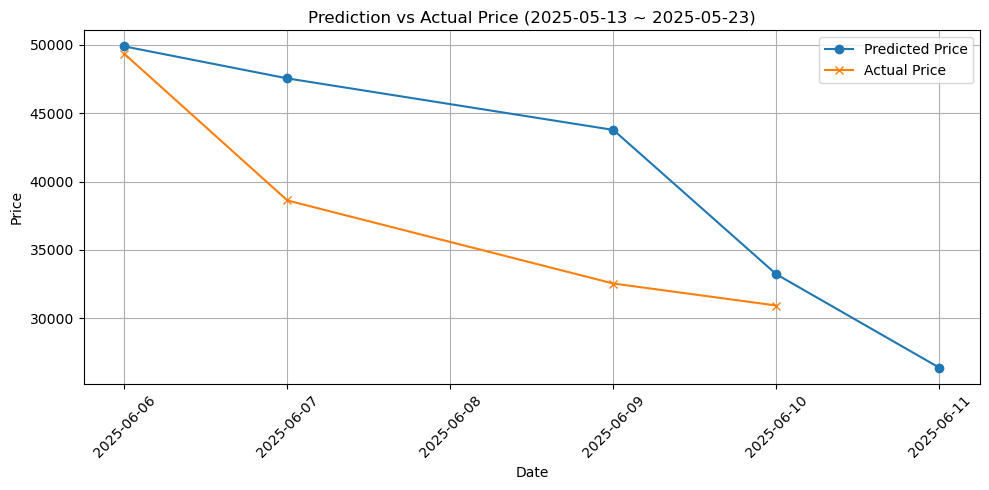

내일 가격: 26387.38
최신 예측 정보: {'year': 2025, 'month': 6, 'day': 11, 'price': 26387.38, 'rate': 'Special'}


In [258]:
import pandas as pd
import matplotlib.pyplot as plt

# 예측 실행
df = pd.read_csv("potato_separated.csv")
predictor = CabbagePredictor()
predictor.fit(df, cutoff_date="2025-06-1", months=[4,5,6,7,8], rate="Special")
predictor.save(rate="Special")

#
result_df = pd.DataFrame(predictor.results, columns=['date', 'predicted', 'actual'])
result_df['date'] = pd.to_datetime(result_df['date'])

# 원하는 구간 추출
filtered = result_df[(result_df['date'] >= '2025-04-19') & (result_df['date'] <= '2025-06-11')]
print(filtered)

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(filtered['date'], filtered['predicted'], label='Predicted Price', marker='o')
plt.plot(filtered['date'], filtered['actual'], label='Actual Price', marker='x')
plt.title('Prediction vs Actual Price (2025-05-13 ~ 2025-05-23)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 마지막 예측 결과 출력
print("내일 가격:", round(predictor.predict_next(), 2))
print("최신 예측 정보:", predictor.post_latest())


In [4]:
df = pd.read_csv("tomato_separated.csv")
predictor = CabbagePredictor()
predictor.fit(df, cutoff_date="2025-05-30", months=[6], rate="HIGH")
predictor.save(rate="HIGH")
result_df = pd.DataFrame(predictor.results, columns=['date', 'predicted', 'actual'])
result_df['date'] = pd.to_datetime(result_df['date'])

# 원하는 구간의 예측 결과(예시: 6월 2일~6월 8일)
print(result_df[(result_df['date'] >= '2025-05-30') & (result_df['date'] <= '2025-06-08')])

print("내일 가격:", round(predictor.predict_next(), 2))
print("최신 예측 정보:", predictor.post_latest())

        date     predicted        actual
0 2025-06-02   8059.258502   7546.000144
1 2025-06-03   7991.673182   8334.000022
2 2025-06-04   8132.512551   9352.000094
3 2025-06-05   9786.851926  10808.000289
4 2025-06-06  11107.036242  10583.000415
5 2025-06-07  11121.403736  10183.000375
6 2025-06-08   9481.487047           NaN
내일 가격: 9481.49
최신 예측 정보: {'year': 2025, 'month': 6, 'day': 8, 'price': 9481.49, 'rate': 'HIGH'}


In [18]:
#지속 모델, 핏 안하고 바로 로드하게 만들었어
df_new = pd.read_csv("cabbage_separated.csv")
predictor = CabbagePredictor()
predictor.load(rate="HIGH")
predictor.update_one_day(df_new, months=[4, 5, 6], rate="HIGH")
predictor.save(rate="HIGH")

예측된 다음날 가격: 6813.42
{'year': 2025, 'month': 5, 'day': 28, 'price': 6813.42, 'rate': 'Special'}
